credit to https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\CSY\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [3]:
train.shape, test.shape

((19579, 3), (8392, 2))

In [4]:
check_null = train.isnull().sum()
check_null[check_null!=0]

Series([], dtype: int64)

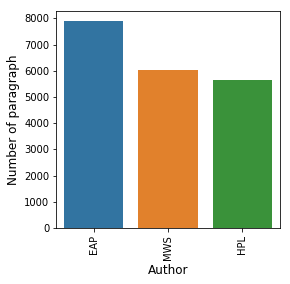

In [5]:
author_cnt = train.author.value_counts()

plt.figure(figsize=(4,4))
sns.barplot(author_cnt.index, author_cnt.values)
plt.ylabel('Number of paragraph', fontsize=12)
plt.xlabel('Author', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [6]:
import string
import nltk
ps = nltk.PorterStemmer()
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    stopwords = nltk.corpus.stopwords.words('english')
    text = " ".join([ps.stem(word) for word in tokens if word not in stopwords])
    return text

In [7]:
train["clean_text"] = train.text.apply(lambda x: clean_text(x))
train["clean_text"].head()

0    process howev afford mean ascertain dimens dun...
1                  never occur fumbl might mere mistak
2    left hand gold snuff box caper hill cut manner...
3    love spring look windsor terrac sixteen fertil...
4    find noth els even gold superintend abandon at...
Name: clean_text, dtype: object

In [8]:
test["clean_text"] = test.text.apply(lambda x: clean_text(x))
test.head()

,id,text,clean_text
0,id02310,"Still, as I urged our leaving Ireland with suc...",still urg leav ireland inquietud impati father...
1,id24541,"If a fire wanted fanning, it could readily be ...",fire want fan could readili fan newspap govern...
2,id00134,And when they had broken down the frail door t...,broken frail door found two cleanli pick human...
3,id27757,While I was thinking how I should possibly man...,think possibl manag without one actual tumbl h...
4,id04081,I am not sure to what limit his knowledge may ...,sure limit knowledg may extend


In [9]:
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words("english"))
import string
## Number of words in the text ##
train["num_words"] = train["text"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train["num_unique_words"] = train["text"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["text"].apply(lambda x: len(set(str(x).split())))

## Number of stopwords in the text ##
train["num_stopwords"] = train["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test["num_stopwords"] = test["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text ##
train["num_punctuations"] =train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["num_punctuations"] =test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

In [10]:
def punct_pct2(text, punc):
    count = sum([1 for char in text if char==punc])
    return round(count/(len(text) - text.count(" ")), 3)*100

In [11]:
train["comma%"] = train.text.apply(lambda x: punct_pct2(x, ','))
train["semicolon%"] = train.text.apply(lambda x: punct_pct2(x, ';'))
train["colon%"] = train.text.apply(lambda x: punct_pct2(x, ':'))
train["question%"] = train.text.apply(lambda x: punct_pct2(x, '?'))

test["comma%"] = test.text.apply(lambda x: punct_pct2(x, ','))
test["semicolon%"] = test.text.apply(lambda x: punct_pct2(x, ';'))
test["colon%"] = test.text.apply(lambda x: punct_pct2(x, ':'))
test["question%"] = test.text.apply(lambda x: punct_pct2(x, '?'))
train.head()

,id,text,author,clean_text,num_words,num_unique_words,num_stopwords,num_punctuations,comma%,semicolon%,colon%,question%
0,id26305,"This process, however, afforded me no means of...",EAP,process howev afford mean ascertain dimens dun...,41,35,19,7,2.1,1.0,0.0,0.0
1,id17569,It never once occurred to me that the fumbling...,HPL,never occur fumbl might mere mistak,14,14,8,1,0.0,0.0,0.0,0.0
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,left hand gold snuff box caper hill cut manner...,36,32,16,5,2.4,0.0,0.0,0.0
3,id27763,How lovely is spring As we looked from Windsor...,MWS,love spring look windsor terrac sixteen fertil...,34,32,13,4,1.7,0.0,0.0,0.0
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,find noth els even gold superintend abandon at...,27,25,11,4,1.4,0.7,0.0,0.0


In [12]:
num_vars = ["comma%", "semicolon%", "question%", "colon%",
            "num_punctuations", "num_stopwords", "num_unique_words", "num_words"]

In [13]:
from gensim.models import doc2vec

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be like "TRAIN_i" where "i" is
    a dummy index of the complaint narrative.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [14]:
x_Train, x_Val, y_Train, y_Val = train_test_split(train, train.author, random_state=1, test_size=0.2)
xTrain = label_sentences(x_Train.clean_text, 'Train')
xVal = label_sentences(x_Val.clean_text, 'Val')
len(xTrain), len(xVal)

In [16]:
xTest = label_sentences(test.clean_text, 'Test')
len(xTest)

8392

In [19]:
all_data = xTrain + xVal + xTest
all_data[:3]

[TaggedDocument(words=['twice', 'waylaid', 'footpad', 'person', 'rigor', 'search', 'inspect'], tags=['Train_0']),
 TaggedDocument(words=['autumn', 'year', 'spirit', 'emigr', 'crept', 'among', 'survivor', 'congreg', 'variou', 'part', 'england', 'met', 'london'], tags=['Train_1']),
 TaggedDocument(words=['mention', 'muriton', 'red', 'tongu', 'cauliflow', 'velouté', 'sauc', 'veal', 'à', 'la', 'st', 'menehoult', 'marinad', 'à', 'la', 'st', 'florentin', 'orang', 'jelli', 'en', 'mosäiqu'], tags=['Train_2'])]

In [20]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

## dbow

In [21]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=2, alpha=0.065, min_alpha=0.05)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|███████████████████████████████████████████████████████████████████████| 27971/27971 [00:00<00:00, 1445828.69it/s]


In [22]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|███████████████████████████████████████████████████████████████████████| 27971/27971 [00:00<00:00, 1006864.78it/s]


Wall time: 44.4 s


In [23]:
train_vectors_dbow = get_vectors(model_dbow, len(xTrain), 300, 'Train')
val_vectors_dbow = get_vectors(model_dbow, len(xVal), 300, 'Val')

In [24]:
model_dbow.save('d2v_dbow.doc2vec')

## dm

In [25]:
model_dm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.05)
model_dm.build_vocab([x for x in tqdm(all_data)])

100%|████████████████████████████████████████████████████████████████████████| 27971/27971 [00:00<00:00, 881076.63it/s]


In [26]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|███████████████████████████████████████████████████████████████████████| 27971/27971 [00:00<00:00, 1445935.61it/s]


Wall time: 44 s


In [27]:
train_vectors_dm = get_vectors(model_dm, len(xTrain), 300, 'Train')
val_vectors_dm = get_vectors(model_dm, len(xVal), 300, 'Val')

In [28]:
model_dm.save('d2v_dm.doc2vec')

In [29]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

## ensemble two models

In [30]:
def get_concat_vectors(model1,model2, corpus_size, vectors_size, vectors_type):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
    return vectors

In [31]:
train_vecs_dbow_dm = get_concat_vectors(model_dbow,model_dm, len(xTrain), 600, 'Train')
val_vecs_dbow_dm = get_concat_vectors(model_dbow,model_dm, len(xVal), 600, 'Val')

In [32]:
train_vecs_dbow_dm

array([[-5.26423790e-02, -1.03586011e-01, -9.34147611e-02, ...,
         2.04044889e-04,  1.58772664e-03, -1.10418745e-03],
       [ 2.05712512e-01,  4.36340570e-02, -1.41410843e-01, ...,
         7.61901319e-04, -1.57967920e-03,  5.10557496e-04],
       [ 1.85213044e-01,  8.65301192e-02, -7.81153142e-02, ...,
         9.47897148e-04, -1.24921316e-05, -1.54612854e-03],
       ...,
       [ 1.55942678e-01,  4.78256643e-02, -1.10023409e-01, ...,
        -1.22167589e-03,  1.18912058e-03,  8.59428546e-04],
       [ 1.14518598e-01,  3.60401385e-02, -1.50026843e-01, ...,
         8.80557403e-04,  1.56548433e-03,  4.80017974e-04],
       [ 1.11187123e-01,  9.98829380e-02,  7.99867362e-02, ...,
        -1.21243251e-03, -8.98093509e-04, -4.60802170e-04]])

In [33]:
train_vecs_dbow_dm.shape

(15663, 600)

In [34]:
train_vars = x_Train[num_vars].reset_index(drop = True)
train_vars.head(2)

,comma%,semicolon%,question%,colon%,num_punctuations,num_stopwords,num_unique_words,num_words
0,2.2,0.0,0.0,0.0,5,10,18,18
1,3.2,0.0,0.0,0.0,5,12,22,27


In [35]:
val_vars = x_Val[num_vars].reset_index(drop = True)
val_vars.head(2)

,comma%,semicolon%,question%,colon%,num_punctuations,num_stopwords,num_unique_words,num_words
0,4.9,0.0,2.4,0.0,3,4,9,9
1,1.8,1.2,0.0,0.0,6,20,31,36


In [37]:
xtrain_all = pd.concat([pd.DataFrame(train_vecs_dbow_dm), train_vars], axis=1)
xval_all = pd.concat([pd.DataFrame(val_vecs_dbow_dm), val_vars], axis=1)
xtrain_all.shape, xval_all.shape

((15663, 608), (3916, 608))

In [38]:
from sklearn.preprocessing import StandardScaler

# scale the data before any neural net:
scl = StandardScaler()
xtrain_scl = scl.fit_transform(xtrain_all)
xval_scl = scl.transform(xval_all)

C:\Users\CSY\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\CSY\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\CSY\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [41]:
from sklearn import preprocessing, decomposition, model_selection, metrics
enc = preprocessing.LabelEncoder()
ytrain_enc = enc.fit_transform(y_Train.values)
yvalid_enc = enc.fit_transform(y_Val.values)

from keras.utils import np_utils
# we need to binarize the labels for the neural net
ytrain_enc = np_utils.to_categorical(ytrain_enc)
yvalid_enc = np_utils.to_categorical(yvalid_enc)

xtrain_scl.shape, ytrain_enc.shape, xval_scl.shape, yvalid_enc.shape

((15663, 608), (15663, 3), (3916, 608), (3916, 3))

In [ ]:
import tensorflow as tf
def custom_loss(eps):
    def lossfunc(y_true, y_pred):
        """Multi class version of Logarithmic Loss metric.
        :param actual: Array containing the actual target classes
        :param predicted: Matrix with class predictions, one probability per class
        """
        actual = y_true
        predicted = y_pred
        # Convert 'actual' to a binary array if it's not already:
        if len(actual.shape) == 1:
            actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
            for i, val in enumerate(actual):
                actual2[i, val] = 1
            actual = actual2
        
        clip = np.clip(predicted, eps, 1 - eps)
        rows = actual.shape[0]
        vsota = tf.sum(actual * np.log(clip))
        return -1.0 / rows * vsota
    return lossfunc

In [44]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping


model_d2v = Sequential()
model_d2v.add(Dense(256, activation='relu'))
model_d2v.add(Dropout(0.7))
model_d2v.add(Dense(512, activation='relu'))
model_d2v.add(Dropout(0.9))
model_d2v.add(Dense(256, activation='relu'))
model_d2v.add(Dropout(0.8))

model_d2v.add(Dense(3))  # this is the output layer
model_d2v.add(Activation('softmax'))
model_d2v.compile(loss='categorical_crossentropy', optimizer='adam')
# model_d2v.compile(loss=custom_loss(1e-15), optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) 
model_d2v.fit(x=xtrain_scl, y=ytrain_enc, validation_data=(xval_scl, yvalid_enc), 
                    epochs=100, batch_size=256, verbose=2, callbacks=[early_stop])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 15663 samples, validate on 3916 samples
Epoch 1/100
 - 3s - loss: 3.3760 - val_loss: 1.0732
Epoch 2/100
 - 2s - loss: 1.5861 - val_loss: 1.0863
Epoch 3/100
 - 2s - loss: 1.2635 - val_loss: 1.0882
Epoch 4/100
 - 2s - loss: 1.1553 - val_loss: 1.0857
Epoch 5/100
 - 2s - loss: 1.0918 - val_loss: 1.0773
Epoch 6/100
 - 2s - loss: 1.0491 - val_loss: 1.0542
Epoch 7/100
 - 2s - loss: 0.9963 - val_loss: 0.9847
Epoch 8/100
 - 2s - loss: 0.9153 - val_loss: 0.8819
Epoch 9/100
 - 2s - loss: 0.8417 - val_loss: 0.8107
Epoch 10/100
 - 2s - loss: 0.7829 - val_loss: 0.7438
Epoch 11/100
 - 2s - loss: 0.7456 - val_loss: 0.7014
Epoch 12/100
 - 2s - loss: 0.7136 - val_loss: 0.6788
Epoch 13/100
 - 2s - loss: 0.6773 - val_loss: 0.6466
Epoch 14/100
 - 2s - loss: 0.6697 - 

# test set

In [45]:
print(test.shape)
test.head(2)

(8392, 11)


,id,text,clean_text,num_words,num_unique_words,num_stopwords,num_punctuations,comma%,semicolon%,colon%,question%
0,id02310,"Still, as I urged our leaving Ireland with suc...",still urg leav ireland inquietud impati father...,19,19,9,3,2.2,0.0,0.0,0.0
1,id24541,"If a fire wanted fanning, it could readily be ...",fire want fan could readili fan newspap govern...,62,49,33,7,2.2,0.0,0.0,0.0


In [46]:
test_vectors_dbow_dm = get_concat_vectors(model_dbow,model_dm,len(xTest), 600, 'Test')
test_vars = test[num_vars].reset_index(drop = True)
xtest_all = pd.concat([pd.DataFrame(test_vectors_dbow_dm), test_vars], axis=1)
xtest_scl = scl.transform(xtest_all)
predictions = model_d2v.predict_proba(xtest_scl)
predictions

C:\Users\CSY\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


array([[1.4744990e-01, 2.4017558e-02, 8.2853246e-01],
       [7.4536675e-01, 1.6391975e-01, 9.0713501e-02],
       [1.9660375e-01, 7.7289927e-01, 3.0496996e-02],
       ...,
       [4.7911134e-01, 3.7519179e-02, 4.8336956e-01],
       [1.4604101e-01, 1.3087759e-02, 8.4087121e-01],
       [3.5947759e-02, 9.6333349e-01, 7.1876281e-04]], dtype=float32)

In [47]:
predictions.shape

(8392, 3)

In [48]:
nn_df = pd.concat([test.id, pd.DataFrame(predictions)], axis=1)
nn_df.columns=["id","EAP","HPL","MWS"]
nn_df.to_csv("nn.csv", index=False)